## Text analysis
For this project it was decided to work with movie scripts as the basis for text analysis. **[641 movie scripts](http://someurl)** were downloaded from the largest source of movie scripts on the World Wide Web, www.imsdb.com. Details about how the movie scripts were downloaded can be found in **[Part 2](http://someurl)**.

First we read in the data from our **[IMDb dataset](http://someurl)** to get the nesscessary information about every English language movie from 1986 to 2016.

Total number of movies from the IMDb dataset is 4377, which is considerably more movies than we have of movie scripts. The text analysis  will therefore only have data about the movies which have movie scripts, discluding information about the rest of movies.

In [236]:
# Read-in imdb data
import csv

movies = {}

with open('imdb_dataset_v7.2_6_actors_complete.tsv') as csvfile:
    reader = csv.DictReader(csvfile, delimiter = "\t")
    for entry in reader:
        movies[
            entry["title"]
        ] = {
        "director":     entry["director"],
        "rating":       entry["rating"],
        "votes":        entry["votes"],
        "year":         entry["year"],
        "genre":        entry["genre"],
        "gross":        entry["gross"],
        "budget":       entry["budget"],
        "run-time":     entry["run-time"] ,
        "actor1":       entry["actor1"],
        "actor1_rank":  entry["actor1_rank"],
        "actor1_sex":   entry["actor1_sex"],
        "actor2":       entry["actor2"],
        "actor2_rank":  entry["actor2_rank"],
        "actor2_sex":   entry["actor2_sex"],
        "actor3":       entry["actor3"],
        "actor3_rank":  entry["actor3_rank"],
        "actor3_sex":   entry["actor3_sex"],
        "actor4":       entry["actor4"],
        "actor4_rank":  entry["actor4_rank"],
        "actor4_sex":   entry["actor4_sex"],
        "actor5":       entry["actor5"],
        "actor5_rank":  entry["actor5_rank"],
        "actor5_sex":   entry["actor5_sex"],
        "actor6":       entry["actor6"],
        "actor6_rank":  entry["actor6_rank"],
        "actor6_sex":   entry["actor6_sex"],
        "plot":         entry["plot"]
        }

Movie scripts have many terms that are not related to the story, which in fact we want to get rid of.

In [237]:
# List of terms associated with movie script writing
movie_scripts_terms = ['written', 'writer', 'int', 'ext', 'day', 'night', 'morning',
                       'evening', 'fade', 'cut', 'continued', 'cont', 'contd', 'continuing',
                       'toward', 'towards', 'overlapping', 'screentalk', 'screen',
                       'talk', 'offscreen', 'pan', 'pans', 'tilt', 'tilts', 'camera',
                       'movie', 'film', 'filming', 'gesture', 'gesturing']

### Tokenize the text
First we create a function to tokenize the words we get from the movie scripts. The list which this functions returns includes no numbers and no punctuations by using regular expressions.

It is also important to not include words that have capital letters within them. The reason for that is all characters names as well as places start with capital letters, which we want to exclude from our text analyse. Stop words, terms associated with writing a movie script and words that have fewer letters than 3 are as well discluded to give better picture of the words the movie scripts are made of.

In [238]:
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# Function for getting tokens from text
def tokens(text):
    # Remove numbers
    no_numbers = re.sub(r'\d+(\.\d+)?', '', text)

    # Remove punctuations and tokenize
    tokens_rm_punct = RegexpTokenizer(r'\w+')
    tokens_without_punct = tokens_rm_punct.tokenize(no_numbers)
    
    # Remove word that have capital letters
    no_starting_capital_letters = []
    for word in tokens_without_punct:
        if(word[0].isupper() == False):
            no_starting_capital_letters.append(word)

    # Remove stop words
    no_stop_words = [word for word in no_starting_capital_letters if word not in stopwords.words('english')]
    
    # Remove terms associated with movie script writing
    no_movie_script_terms = [word for word in no_stop_words if word not in movie_scripts_terms]
    
    # Remove words that have less than 3 characters
    filtered_words = [word for word in no_movie_script_terms if len(word) > 2]

    return filtered_words

### Reading in the movie scripts
The files containing the movie scripts are in .txt format and we read them in by encoding them in unicode.

In [239]:
import os
import io

# Read-in movie scripts and add words to a dictonary of tokens
path = './scripts/'

scripts_tokens = {}
for filename in os.listdir(path):
    if("." in filename[-5:]):
        # Replace '.' when it appears after the year in filenames with '/' to match the imdb dataset
        correct_movie_name = filename.replace(".", "/")
        
        f = io.open(path + filename, 'r', encoding='utf8')
        scripts_tokens[correct_movie_name] = tokens(f.read())
    else:
        f = io.open(path + filename, 'r', encoding='utf8')
        scripts_tokens[filename] = tokens(f.read())

### Sentimental analysis
We want to see if it relates to the genre, how positive or negative a movie is based on its movie script.

To see how positive or negative a movie script is, the LabMT wordlist was downloaded. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter (Data Set S1)](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752).

The list was generated by collecting tweets over a three year period running from September 9, 2008 to September 18, 2011. To the nearest million, the data set comprises 46.076 billion words contained in 4.586 billion tweets posted by over 63 million individual users.

For the evaluations, users on Mechanical Turk were asked to rate how a given word made them feel on a nine point integer scale, obtaining 50 independent evaluations per word.

The data set consists of 10,222 words and their average happiness evaluations according to users on Mechanical Turk.

In [240]:
import csv

# Go through the data Data_Set_S1.txt and list words and their happiness average into a dictonary
word_sentiment_dic = {}
with open('./Data_Set_S1.txt', 'r') as f:
    # Skip the headers
    lines_after_3 = f.readlines()[3:]
    reader = csv.reader(lines_after_3, delimiter='\t')
    for row in reader:
        word = row[0]
        happiness_avg = row[2]
        word_sentiment_dic[word] = happiness_avg

Function to determine how positive or negative a word is (its sentimental score).

In [241]:
def get_sentiment_values(tokens):
    tokens_happiness_avg = []
    for word in tokens:
        # Add to list if the word is found, otherwise not
        if(word in word_sentiment_dic):
            tokens_happiness_avg.append(float(word_sentiment_dic[word]))
    return tokens_happiness_avg

We create a dictionary containing every movie which has a movie script as a key, and its values are sentiment score for every word within the movie script.

In [242]:
import numpy as np

# Get sentiment value for each token from the scripts
movie_scripts_sentiment = {}
for movie in scripts_tokens:
    movie_scripts_sentiment[movie] = get_sentiment_values(scripts_tokens[movie])

Average sentiment score is then calculated for every movie script.

In [243]:
# Get average sentiment value for each script
movie_scripts_sentiment_avg = {}
for movie in movie_scripts_sentiment:
    movie_scripts_sentiment_avg[movie] = np.average(movie_scripts_sentiment[movie])

Now that we have average sentiment score for every movie, we can print out the top 10 positive and negative movie scripts. Higher sentiment score means the movie script has more positive words than negative words on average.

In [244]:
import operator

# Top-10 negative movie scripts based on sentiment analysis
movie_scripts_sentiment_avg_sorted = sorted(movie_scripts_sentiment_avg.items(), key=operator.itemgetter(1))
print "Top-10 negative movie scripts based on sentiment analysis"
for i in movie_scripts_sentiment_avg_sorted[:10]:
    print(str(i[0]) + ": " + str(i[1]))

Top-10 negative movie scripts based on sentiment analysis
Army of Darkness (1992): 5.31525757576
Platoon (1986): 5.32206329951
The Crow (1994): 5.32211348684
Basic (2003): 5.33211344336
Day of the Dead (2008) (V): 5.33463873626
Saw (2004): 5.33751343932
Tremors (1990): 5.3418790443
Judge Dredd (1995): 5.34603737338
Soldier (1998/I): 5.34659166583
Blade II (2002): 5.34694065162


In [245]:
# Top-10 positive movie scripts based on sentiment analysis
movie_scripts_sentiment_avg_sorted = sorted(movie_scripts_sentiment_avg.items(), key=operator.itemgetter(1), reverse=True)
print "Top-10 positive movie scripts based on sentiment analysis"
for i in movie_scripts_sentiment_avg_sorted[:10]:
    print(str(i[0]) + ": " + str(i[1]))

Top-10 positive movie scripts based on sentiment analysis
Midnight in Paris (2011): 5.80318045862
Bridesmaids (2011/I): 5.75815061203
The Perks of Being a Wallflower (2012): 5.75303769046
Clueless (1995): 5.74288487832
Sex and the City (2008): 5.74161941964
The Bling Ring (2013): 5.73512627291
Saving Mr. Banks (2013): 5.73458253003
The Family Man (2000): 5.73050610628
Music of the Heart (1999): 5.72940391224
Peggy Sue Got Married (1986): 5.72683992259


This results were expected. Movies that are topping the negative lists have darker themes than movies topping the positive list, which have more lighter themes.

We also want to find out how the directors are ranking based on their movies' sentiments scores. To have the list more accurate we are excluding directors that have directed less than 2 movies in the dataset for movie scripts.

In [246]:
from collections import defaultdict

# Add sentiment scores to each director
movie_scripts_directors_sentiments = defaultdict(list)
for movie in scripts_tokens:
    movie_scripts_directors_sentiments[movies[movie]["director"]].append(movie_scripts_sentiment_avg[movie])

In [247]:
# Calculate the average sentiment score for each director
movie_scripts_directors_sentiment_avg = {}
for director, sentiment_scores in movie_scripts_directors_sentiments.iteritems():
    # Disclude directors who have directed 2 movies or less
    if(len(sentiment_scores) > 2):
        movie_scripts_directors_sentiment_avg[director] = np.average(sentiment_scores)

In [248]:
# Top-10 negative directors based on sentiment analysis
movie_scripts_directors_sentiment_avg_sorted = sorted(movie_scripts_directors_sentiment_avg.items(), key=operator.itemgetter(1))
print "Top-10 negative directors based on sentiment analysis"
for i in movie_scripts_directors_sentiment_avg_sorted[:10]:
    print(str(i[0]) + ": " + str(i[1]))

Top-10 negative directors based on sentiment analysis
Alex Proyas: 5.38538545141
John McTiernan: 5.39949320603
Renny Harlin: 5.40513683052
Guillermo del Toro: 5.40923648367
Paul W.S. Anderson: 5.42033460888
Michael (I) Bay: 5.44635840041
Sam Raimi: 5.44659580176
Paul (I) Verhoeven: 5.45136034171
Ron (I) Howard: 5.45377046276
Guy Ritchie: 5.4562533964


In [249]:
# Top-10 positive directors based on sentiment analysis
movie_scripts_directors_sentiment_avg_sorted = sorted(movie_scripts_directors_sentiment_avg.items(), key=operator.itemgetter(1), reverse=True)
print "Top-10 positive directors based on sentiment analysis"
for i in movie_scripts_directors_sentiment_avg_sorted[:10]:
    print(str(i[0]) + ": " + str(i[1]))

Top-10 positive directors based on sentiment analysis
Cameron (I) Crowe: 5.70082266725
Woody Allen: 5.68673391417
James L. Brooks: 5.65280563364
Bennett (I) Miller: 5.63250851221
Paul Thomas (I) Anderson: 5.60362698178
Jonathan Demme: 5.59856968488
Henry Selick: 5.59515200213
Robert Zemeckis: 5.5728983279
Anthony Minghella: 5.56647112957
Brett Ratner: 5.56450542717


Here are the results not as decisive as with the movies. This is due to the limitations of the dataset. Allthough, we can see that directors that are directing comedy and more upbeat movies are ranking at the top of the positive list (Cameron Crowe, Woody Allen and James L. Brooks) and directors asscoiated with action movies are ranking high in the negative list (Alex Proyas, Guillermo del Toro, Michael Bay and Sam Raimi).

Next thing will be looking at how the actors rank. As with directors, we are excluding actors that have appear in 2 movies or less.

In [250]:
actors_list = ["actor1", "actor2", "actor3", "actor4", "actor5", "actor6"]

# Add sentiment scores to each actor
movie_scripts_actors_sentiments = defaultdict(list)
for movie in scripts_tokens:
    for actor in actors_list:
        movie_scripts_actors_sentiments[movies[movie][actor]].append(movie_scripts_sentiment_avg[movie])

In [251]:
# Calculate the average sentiment score for each actor
movie_scripts_actors_sentiment_avg = {}
for actor, sentiment_scores in movie_scripts_actors_sentiments.iteritems():
    # Disclude actors who have appeared in 2 movies or less
    if(len(sentiment_scores) > 2):
        movie_scripts_actors_sentiment_avg[actor] = np.average(sentiment_scores)

In [252]:
# Top-10 negative actors based on sentiment analysis
movie_scripts_actors_sentiment_avg_sorted = sorted(movie_scripts_actors_sentiment_avg.items(), key=operator.itemgetter(1))
print "Top-10 negative actors based on sentiment analysis"
for i in movie_scripts_actors_sentiment_avg_sorted[:10]:
    print(str(i[0]) + ": " + str(i[1]))

Top-10 negative actors based on sentiment analysis
Forest Whitaker: 5.38696512673
David Morse: 5.3943744673
Tom Savini: 5.40530097627
John Leguizamo: 5.42322665994
Taye Diggs: 5.42650666406
Ron Perlman: 5.42739500389
Ben Foster: 5.42829341784
Ewen Bremner: 5.42908744838
Courteney Cox: 5.43081948785
Jason Isaacs: 5.4314803348


In [253]:
# Top-10 positive actors based on sentiment analysis
movie_scripts_actors_sentiment_avg_sorted = sorted(movie_scripts_actors_sentiment_avg.items(), key=operator.itemgetter(1), reverse=True)
print "Top-10 positive actors based on sentiment analysis"
for i in movie_scripts_actors_sentiment_avg_sorted[:10]:
    print(str(i[0]) + ": " + str(i[1]))

Top-10 positive actors based on sentiment analysis
Garry Marshall: 5.68252372542
Anthony Michael Hall: 5.68216562581
Joan Cusack: 5.67676420784
Michael Sheen: 5.67045527413
Paul Rudd: 5.66780866284
Olivia Thirlby: 5.66609008895
Jim Cummings: 5.66587103372
Bradley Whitford: 5.66212769672
Zach Galifianakis: 5.65795444584
Alan Arkin: 5.65774269792


The results here are little more random. The reason for that is that we would probably need much more movie scripts to find out how the actors would rank accurately. Forest Whitaker, an Oscar Winner, is at the top of the negative list. He is mainly starring in drama and action movies. Courteney Cox, mainly associated with comedy movies is somehow at the top 10 in the negative list, an odd one out. Comedy actors, like Joan Cusack, Michael Sheen, Paul Rudd and Zach Galifianakis are at the top of the positive list, while drama and action actors are at the top of the negative list. So the list is somewhat accurate, and can give us clues which movies actors are likely to star in.

Next up are the genres. It would be obvious that comedy movies would be more positive than horror movies, but does the data containing 641 movie scripts confirm that assumption? To give better results genres with less than 10 movies are excluded.

In [254]:
# Add genre to each movie
movie_scripts_genres = defaultdict(list)
for movie in scripts_tokens:
    movie_scripts_genres[movie].append(movies[movie]["genre"])

In [255]:
# Get list of movies for each genre
movie_scripts_genres = defaultdict(list)
for movie in scripts_tokens:
    movie_scripts_genres[movies[movie]["genre"]].append(movie)

In [256]:
# Add sentiment scores to each genre
movie_scripts_genres_sentiments = defaultdict(list)
for movie in scripts_tokens:
    movie_scripts_genres_sentiments[movies[movie]["genre"]].append(movie_scripts_sentiment_avg[movie])

In [257]:
# Calculate the average sentiment score for each genre
movie_scripts_genres_sentiment_avg = {}
for genre, sentiment_scores in movie_scripts_genres_sentiments.iteritems():
    # Disclude genres that have less than 10 movies
    if(len(sentiment_scores) > 9):
        movie_scripts_genres_sentiment_avg[genre] = np.average(sentiment_scores)

In [258]:
# Sentiment scores for genres
movie_scripts_genres_sentiment_avg_sorted = sorted(movie_scripts_genres_sentiment_avg.items(), key=operator.itemgetter(1))
print "Sentiment scores for genres from negative to positive"
for i in movie_scripts_genres_sentiment_avg_sorted:
    print(str(i[0]) + ": " + str(i[1]))

Sentiment scores for genres from negative to positive
Action: 5.45712343571
Horror: 5.46539287319
Mystery: 5.49761827646
Crime: 5.50364935555
Adventure: 5.5497598934
Drama: 5.56692807715
Biography: 5.58419956585
Comedy: 5.59980973298


This results confirms the assumption. Comedy movies are the most positive genre out there. And it shouldn't surprise anyone that action, horror and crime are ranking higher in negativity than other genres.

In [260]:
from collections import Counter

# Add number of movie scripts in each genre to a dict
genre_num_of_scripts = {}
for genre in movie_scripts_genres:
    genre_num_of_scripts[genre] = len(movie_scripts_genres[genre])
    
# Sort by number of movie scripts
genre_num_of_scripts_sorted = sorted(genre_num_of_scripts.items(), key=operator.itemgetter(1), reverse=True)

print "Number of movie scipts in a genre"
for i in genre_num_of_scripts_sorted:
    print(str(i[0]) + ": " + str(i[1]))

Number of movie scipts in a genre
Action: 184
Comedy: 144
Drama: 102
Crime: 65
Adventure: 48
Biography: 45
Horror: 31
Mystery: 10
Animation: 6
Fantasy: 4
Sci-Fi: 1
Romance: 1


### Wordcloud using tf-idf
We want to see if some words are more used than others within a specific genre and if it's possible to see any themes within the genres.

To do that we use [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) to determine how frequent words are and their importance within a specific genre.

We start with determining the term frequency of a word within its genre.

In [261]:
# Count how often a token appears in a specific genre (tf values)
def tokens_tf_genre(tokens_genre):
    movie_scripts_genre_tokens = []
    for movie in tokens_genre:
        movie_scripts_genre_tokens += scripts_tokens[movie]

    tokens_counter = Counter(movie_scripts_genre_tokens)
    # Combine list of keys and values
    tokens_tf = zip(tokens_counter.keys(), tokens_counter.values())
    # Delete duplicates and sort
    tokens_tf_sorted = sorted(set(tokens_tf))
    return tokens_tf_sorted

Next is calculating the idf to determine how important that word is.

In [262]:
import math

# Calculate idf values for each word in a genre
def tokens_idf_genre(tokens_genre):
    # Get get every word in the corpus (all movies)
    total_word_list = []
    for movie in tokens_genre:
        # Delete duplicated tokens from every movie script
        total_word_list += set(scripts_tokens[movie])
        
    # Count how often a token appears in a corpus for a genre
    # (equals to how many movie scripts that token is in)
    total_word_list_count = Counter(total_word_list)
   
    # Delete duplicates and sort
    total_word_list_sorted = sorted(set(total_word_list))
    
    
    idf_values = []
    for token in total_word_list_sorted:
        # log(Total number of articles / how many documents have that token)
        idf_value = math.log(len(tokens_genre)/float(total_word_list_count[token]))
        idf_values.append(idf_value)
    
    # Combine list of keys and values
    tokens_idf = zip(total_word_list_sorted, idf_values)
    return tokens_idf

Tf-idf is calculated by multiplying the values for tf and idf together.

In [263]:
# Calculate tf-idf values for each word in a genre
def tokens_tfidf_genre(tokens_tf, tokens_idf):
    # Unzip lists to get values
    tokens_tf, values_tf = zip(*tokens_tf)
    tokens_idf, values_idf = zip(*tokens_idf)
    # Multiply tf and idf values
    tokens_tfidf_values = [a*b for a, b in zip(values_tf, values_idf)]
    # Combine list of keys and values
    tokens_tfidf = zip(tokens_tf, tokens_tfidf_values)
    return tokens_tfidf

The Wordcloud image takes a string of words as an argument and displays an image based on how often the words appear in the string.

Analysis of the Wordcloud images for each genre is after the last Wordcloud image.

In [264]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# Function for creating a Wordcloud image
def wordcloud_image(tfidf):
    wordcloud_text = ""
    for i in tfidf:
        num_of_repeats = int(round(i[1]))
        wordcloud_text += (num_of_repeats * (i[0] + " "))
        
    wordcloud = WordCloud(width=1600, height=800).generate(wordcloud_text)
    plt.figure(figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

In [265]:
# Creates Wordcloud image by using tf-idf
def wordcloud_tfidf(name_of_genre):
    name_of_genre_tf = tokens_tf_genre(movie_scripts_genres[name_of_genre])
    name_of_genre_idf = tokens_idf_genre(movie_scripts_genres[name_of_genre])
    name_of_genre_tfidf = tokens_tfidf_genre(name_of_genre_tf, name_of_genre_idf)
    
    print("Number of movie scripts in genre: " + str(len(movie_scripts_genres[name_of_genre])))
    print("Movie scripts represented in the image")
    print(str(movie_scripts_genres[name_of_genre]))
    
    wordcloud_image(name_of_genre_tfidf)

Number of movie scripts in genre: 184
Movie scripts represented in the image
['Serenity (2005)', 'Pineapple Express (2008)', 'Defiance (2008/I)', 'Hanna (2011)', 'Tomorrow Never Dies (1997)', 'Brick (2005)', 'Looper (2012)', 'Eagle Eye (2008)', 'Conan the Barbarian (2011)', 'Predator (1987)', 'Day of the Dead (2008) (V)', 'Drive Angry (2011)', 'Resident Evil (2002)', 'Fair Game (1995)', 'Hellboy (2004)', 'Three Kings (1999)', 'The Time Machine (2002)', 'Independence Day (1996)', 'Reindeer Games (2000)', 'Sherlock Holmes (2009)', 'Miami Vice (2006)', 'Saving Private Ryan (1998)', 'Deep Rising (1998)', 'Terminator Salvation (2009)', 'RocknRolla (2008)', 'Land of the Dead (2005)', 'Ronin (1998)', "Smokin' Aces (2006)", 'The Avengers (1998)', 'Hard Rain (1998)', '9 (2009/I)', 'Die Hard (1988)', 'Basic (2003)', 'Ninja Assassin (2009)', 'Absolute Power (1997)', 'Cradle 2 the Grave (2003)', 'Darkman (1990)', 'The Bourne Ultimatum (2007)', 'How to Train Your Dragon (2010)', 'Rush Hour (1998)',

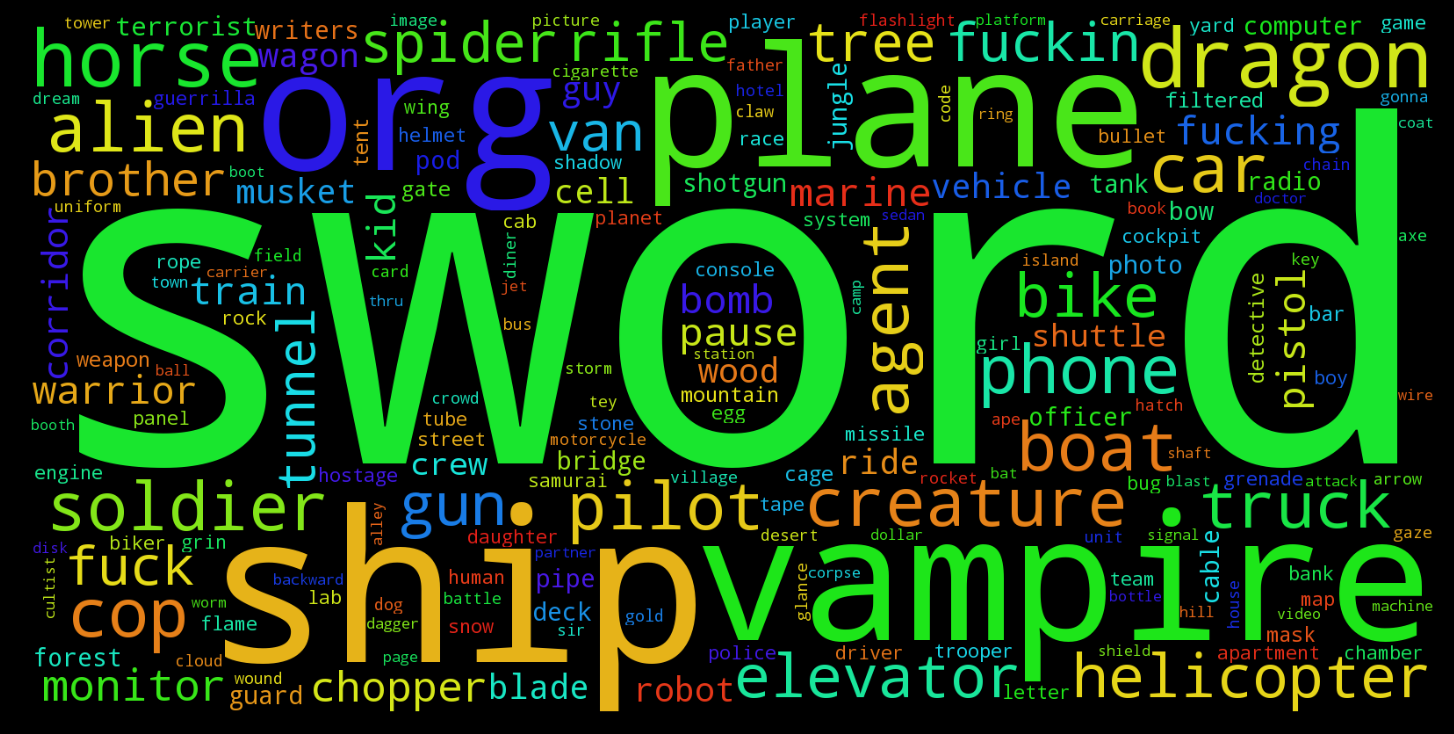

In [266]:
# Wordcloud image for Action genre
wordcloud_tfidf("Action")

Number of movie scripts in genre: 144
Movie scripts represented in the image
['Drop Dead Gorgeous (1999)', 'In the Loop (2009)', 'Very Bad Things (1998)', 'Being Human (1994)', 'Tin Men (1987)', 'Drag Me to Hell (2009)', 'Extract (2009)', 'The Kids Are All Right (2010)', 'Synecdoche, New York (2008)', "My Best Friend's Wedding (1997)", 'New York Minute (2004/I)', 'Garden State (2004)', 'Pretty Woman (1990)', 'Silver Linings Playbook (2012)', 'Barton Fink (1991)', "Henry's Crime (2010)", 'Detroit Rock City (1999)', 'Analyze That (2002)', 'Tremors (1990)', 'American Pie (1999)', "You've Got Mail (1998)", 'Manhattan Murder Mystery (1993)', 'Runaway Bride (1999)', 'Intolerable Cruelty (2003)', 'Juno (2007)', 'Freaked (1993)', 'The Ladykillers (2004)', 'The Mask (1994)', 'Larry Crowne (2011)', 'Raising Arizona (1987)', 'Horrible Bosses (2011)', 'Big (1988)', 'Hesher (2010)', 'Superbad (2007)', 'The American President (1995)', 'Living in Oblivion (1995)', 'No Strings Attached (2011/I)', "It'

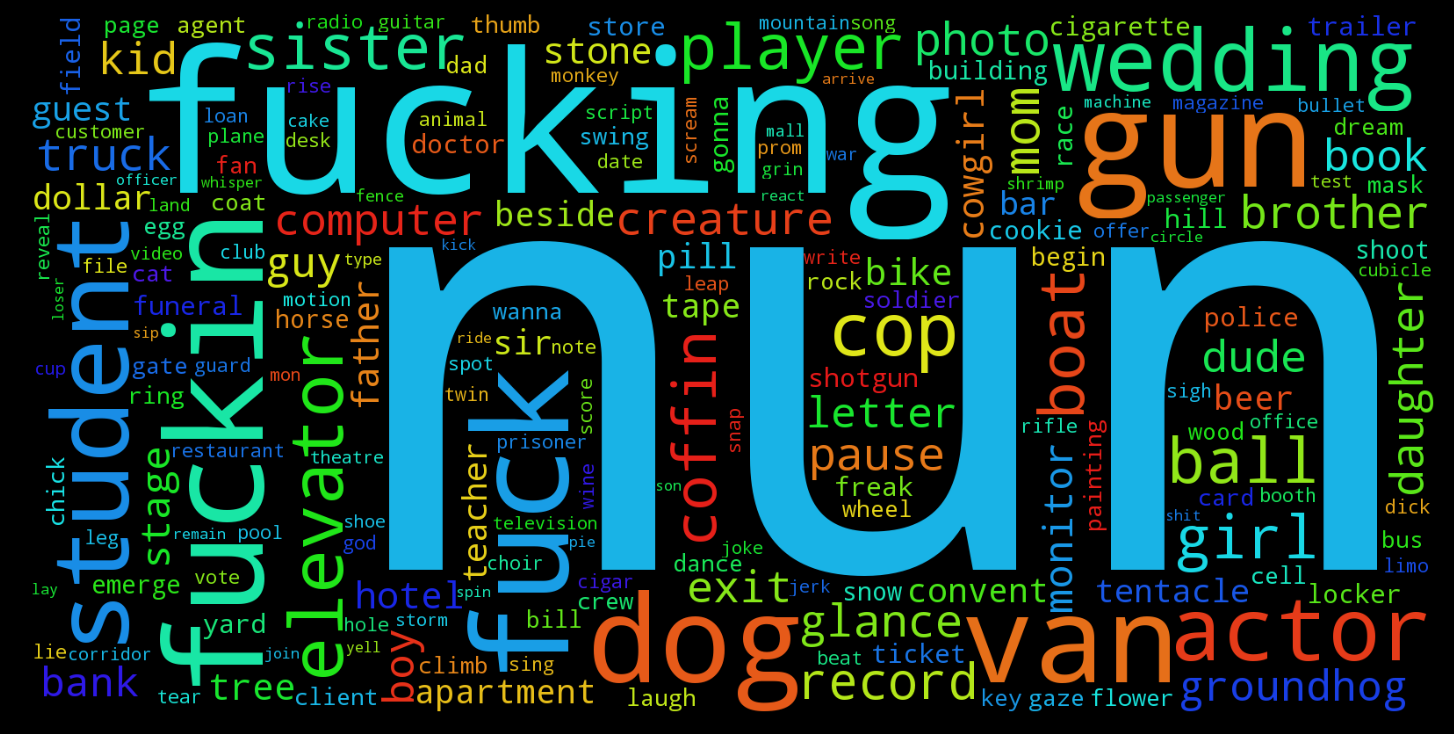

In [267]:
# Wordcloud image for Comedy genre
wordcloud_tfidf("Comedy")

Number of movie scripts in genre: 102
Movie scripts represented in the image
['War Horse (2011)', 'Constantine (2005)', 'Water for Elephants (2011)', 'Remember Me (2010)', 'Zero Dark Thirty (2012)', "Jacob's Ladder (1990/I)", 'The Roommate (2011/I)', 'Martha Marcy May Marlene (2011)', 'Kafka (1991)', 'Black Swan (2010)', 'Meet Joe Black (1998)', 'Mud (2012)', 'Up in the Air (2009/I)', 'Edward Scissorhands (1990)', 'Anna Karenina (1997)', 'Flight (2012/I)', 'Angel Eyes (2001)', 'Take Shelter (2011)', "All the King's Men (2006)", 'The Perks of Being a Wallflower (2012)', 'After.Life (2009)', 'Buried (2010)', 'Good Will Hunting (1997)', 'The Box (2009/I)', 'Platoon (1986)', 'Valkyrie (2008)', 'The Horse Whisperer (1998)', 'The Good Girl (2002)', 'The Wrestler (2008)', 'Body of Evidence (1993)', 'Django Unchained (2012)', 'Ghost (1990)', 'Sphere (1998)', 'Sling Blade (1996)', 'Trainspotting (1996)', 'Gattaca (1997)', 'Warrior (2011)', 'The Majestic (2001)', '12 and Holding (2005)', 'Americ

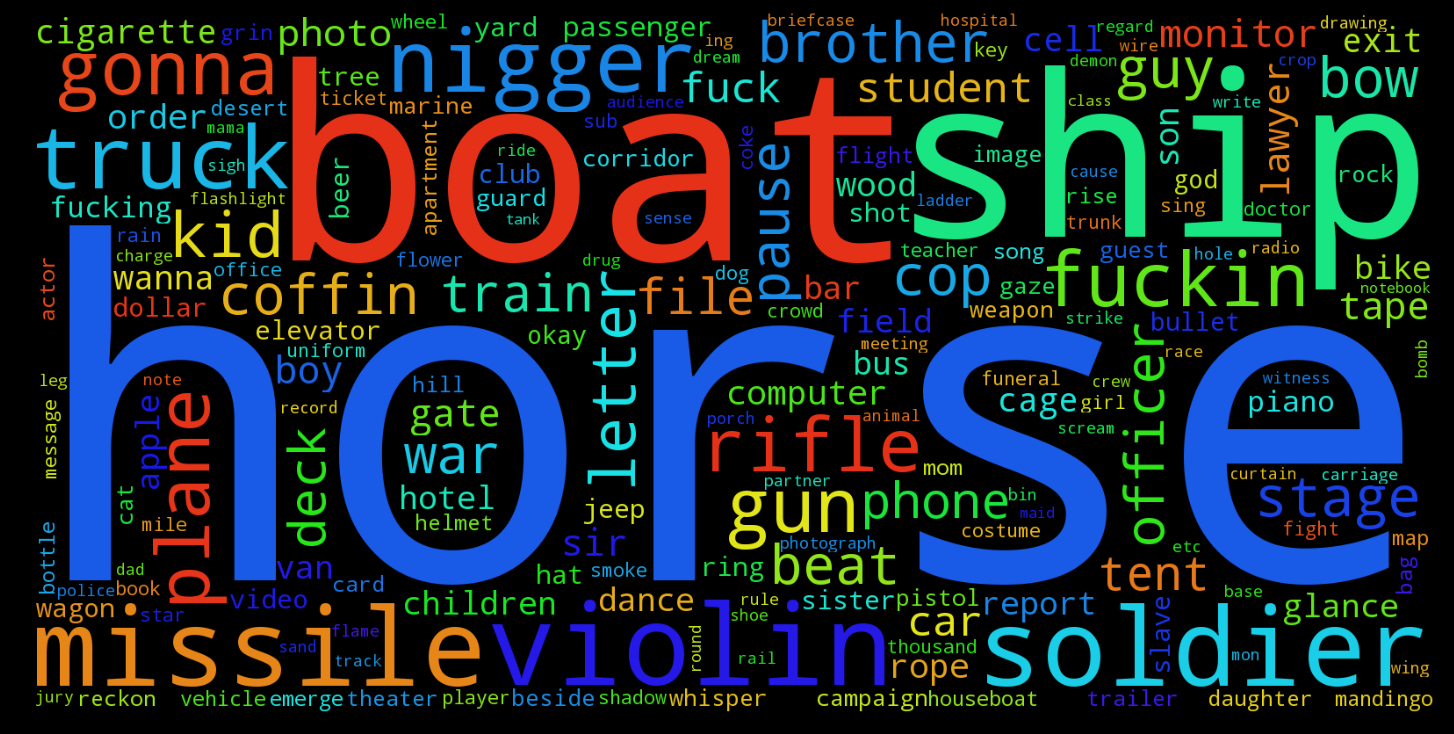

In [268]:
# Wordcloud image for Drama genre
wordcloud_tfidf("Drama")

Number of movie scripts in genre: 65
Movie scripts represented in the image
['Law Abiding Citizen (2009)', 'American History X (1998)', 'The Shawshank Redemption (1994)', 'Panic Room (2002)', 'Se7en (1995)', 'True Romance (1993)', 'American Psycho (2000)', 'Unknown (2006)', 'Misery (1990)', 'The Talented Mr. Ripley (1999)', 'John Q (2002)', 'U Turn (1997)', 'Frequency (2000)', 'The Green Mile (1999)', 'Out of Sight (1998)', 'In the Bedroom (2001)', 'Honeydripper (2007)', 'Training Day (2001)', "Ocean's Eleven (2001)", 'The Box (2007/II)', 'Basic Instinct (1992)', 'American Hustle (2013)', "Miller's Crossing (1990)", 'Light Sleeper (1992)', 'Changeling (2008)', 'Fargo (1996)', 'The Limey (1999)', 'L.A. Confidential (1997)', 'Jackie Brown (1997)', 'Wall Street (1987)', 'The Cooler (2003)', 'Taking Lives (2004)', 'The Lincoln Lawyer (2011)', 'The Usual Suspects (1995)', 'The Black Dahlia (2006)', 'Suspect Zero (2004)', 'The Departed (2006)', 'Pulp Fiction (1994)', 'Wild Things (1998)', 'L

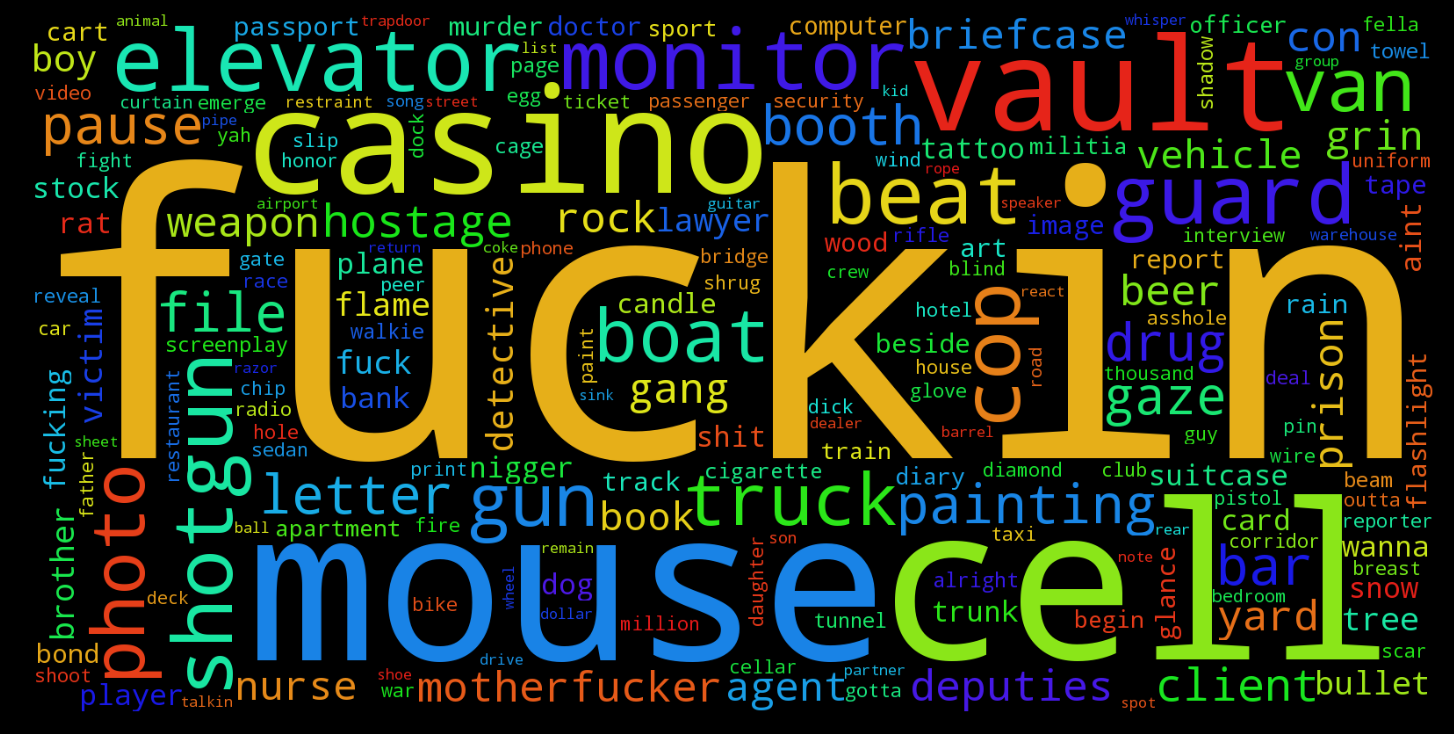

In [269]:
# Wordcloud image for Crime genre
wordcloud_tfidf("Crime")

Number of movie scripts in genre: 48
Movie scripts represented in the image
['Frozen (2013/I)', 'Bean (1997)', 'War of the Worlds (2005)', 'Despicable Me 2 (2013)', 'Up (2009)', 'Jurassic Park (1993)', 'Cars 2 (2011)', 'Thelma & Louise (1991)', 'Moonrise Kingdom (2012)', 'Mulan (1998)', 'The Abyss (1989)', 'ParaNorman (2012)', 'The Revenant (2015)', 'All About Steve (2009)', 'Shrek the Third (2007)', 'Dogma (1999)', 'Almost Famous (2000)', "The Hitchhiker's Guide to the Galaxy (2005)", 'Shrek (2001)', 'The Beach (2000/I)', 'Interstellar (2014)', 'Monte Carlo (2011)', 'Labyrinth (1986)', 'The Brothers Bloom (2008)', 'The Rescuers Down Under (1990)', 'Year One (2009)', 'Prometheus (2012/I)', 'Cold Mountain (2003)', 'Toy Story (1995)', 'Rise of the Guardians (2012)', 'Aladdin (1992)', 'Inglourious Basterds (2009)', 'Men in Black (1997)', 'True Grit (2010)', 'Fear and Loathing in Las Vegas (1998)', 'Big Fish (2003)', 'Anastasia (1997)', 'Finding Nemo (2003)', 'Antz (1998)', 'White Squall (

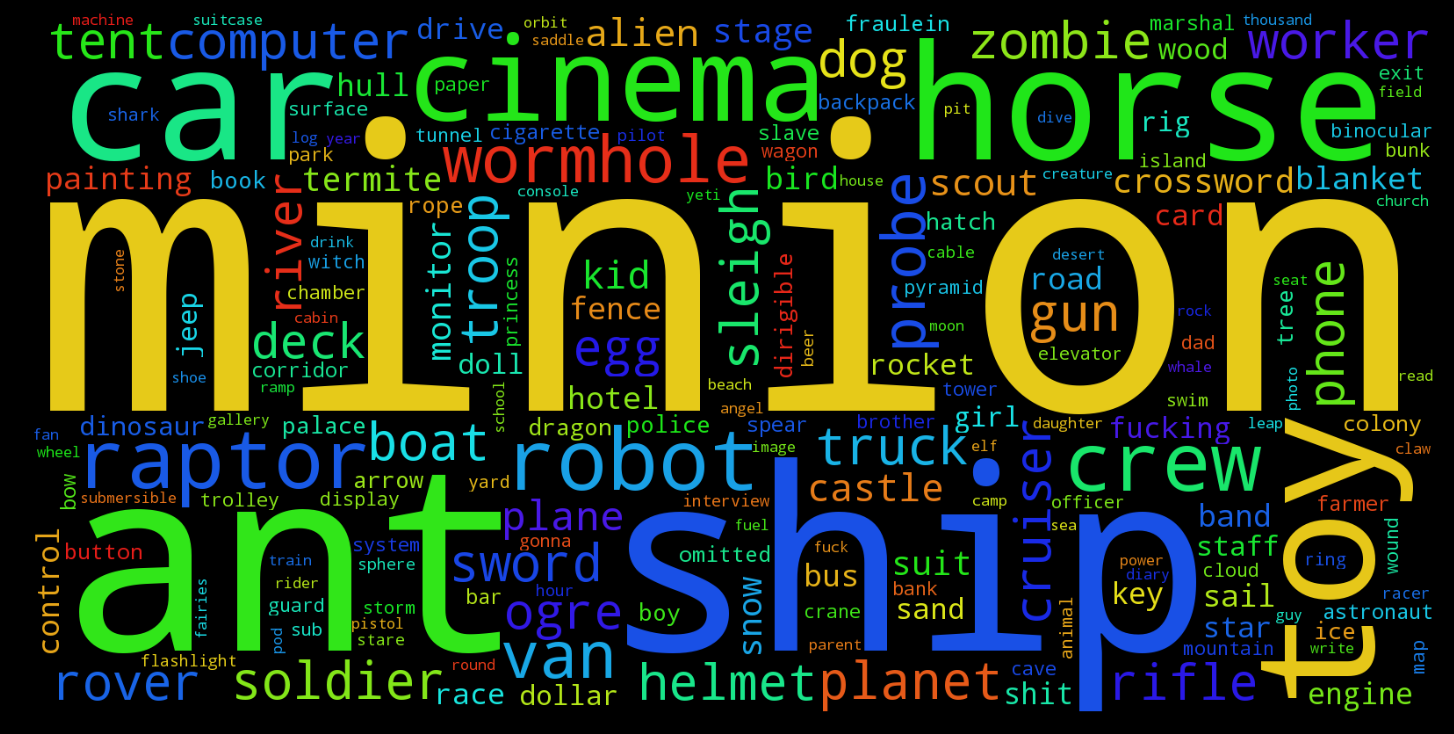

In [270]:
# Wordcloud image for Adventure genre
wordcloud_tfidf("Adventure")

Number of movie scripts in genre: 45
Movie scripts represented in the image
['Margin Call (2011)', "The King's Speech (2010)", 'The Iron Lady (2011)', 'Milk (2008/I)', 'Argo (2012)', 'Donnie Brasco (1997)', 'The Insider (1999)', 'Malcolm X (1992)', 'The Other Boleyn Girl (2008)', 'Fair Game (2010/I)', 'Gods and Monsters (1998)', 'Public Enemies (2009)', 'The Damned United (2009)', 'Basquiat (1996)', 'I Love You Phillip Morris (2009)', 'Foxcatcher (2014)', 'The Pianist (2002)', 'The Wolf of Wall Street (2013)', 'How to Lose Friends & Alienate People (2008)', 'Erin Brockovich (2000)', 'Confessions of a Dangerous Mind (2002)', 'Lincoln (2012)', 'Casino (1995)', 'Saving Mr. Banks (2013)', 'The Sessions (2012)', 'Braveheart (1995)', 'Man on the Moon (1999)', 'Blow (2001)', 'The Queen (2006)', 'Awakenings (1990)', 'Moneyball (2011)', 'Creation (2009/I)', 'Capote (2005)', 'The Blind Side (2009)', 'American Gangster (2007)', '12 Years a Slave (2013)', 'My Week with Marilyn (2011)', 'The Social

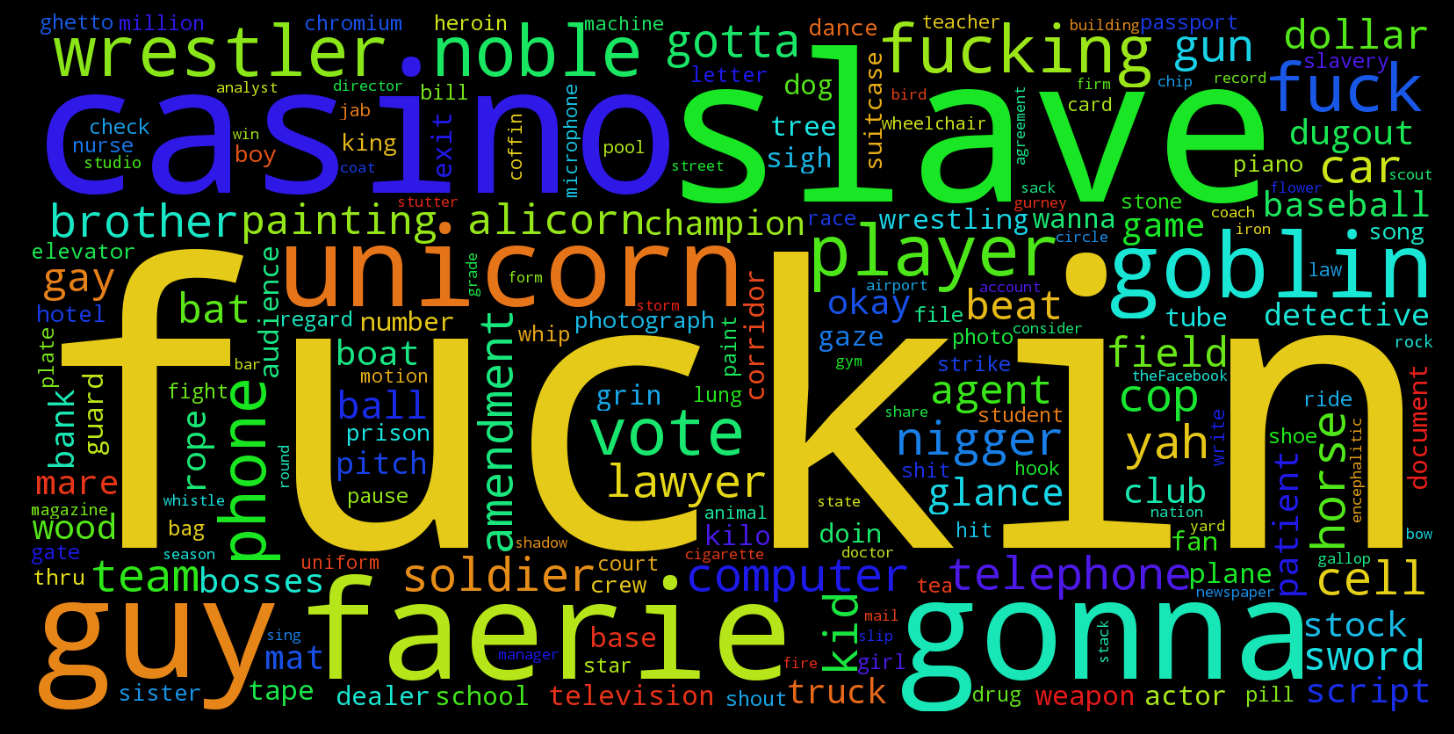

In [271]:
# Wordcloud image for Biography genre
wordcloud_tfidf("Biography")

Number of movie scripts in genre: 31
Movie scripts represented in the image
['I Spit on Your Grave (2010)', 'The Cell (2000)', 'They (2002)', 'The Relic (1997)', 'The Ruins (2008)', 'Cherry Falls (2000)', 'Saw (2004)', 'House of 1000 Corpses (2003)', 'The Thing (2011/I)', 'Mimic (1997)', 'Mirrors (2008/I)', 'Prom Night (2008/I)', 'I Still Know What You Did Last Summer (1998)', 'Lord of Illusions (1995)', 'Case 39 (2009)', 'Scream 2 (1997)', 'Event Horizon (1997)', 'Psycho (1998)', 'Final Destination (2000)', 'Stir of Echoes (1999)', 'Ghost Ship (2002)', 'When a Stranger Calls (2006)', 'Alone in the Dark (2005)', 'Friday the 13th (2009)', 'The Hills Have Eyes (2006)', 'Scream 3 (2000)', 'Final Destination 2 (2003)', 'Insidious (2010/I)', 'The Grudge (2004)', 'Pet Sematary (1989)', 'Scream (1996)']


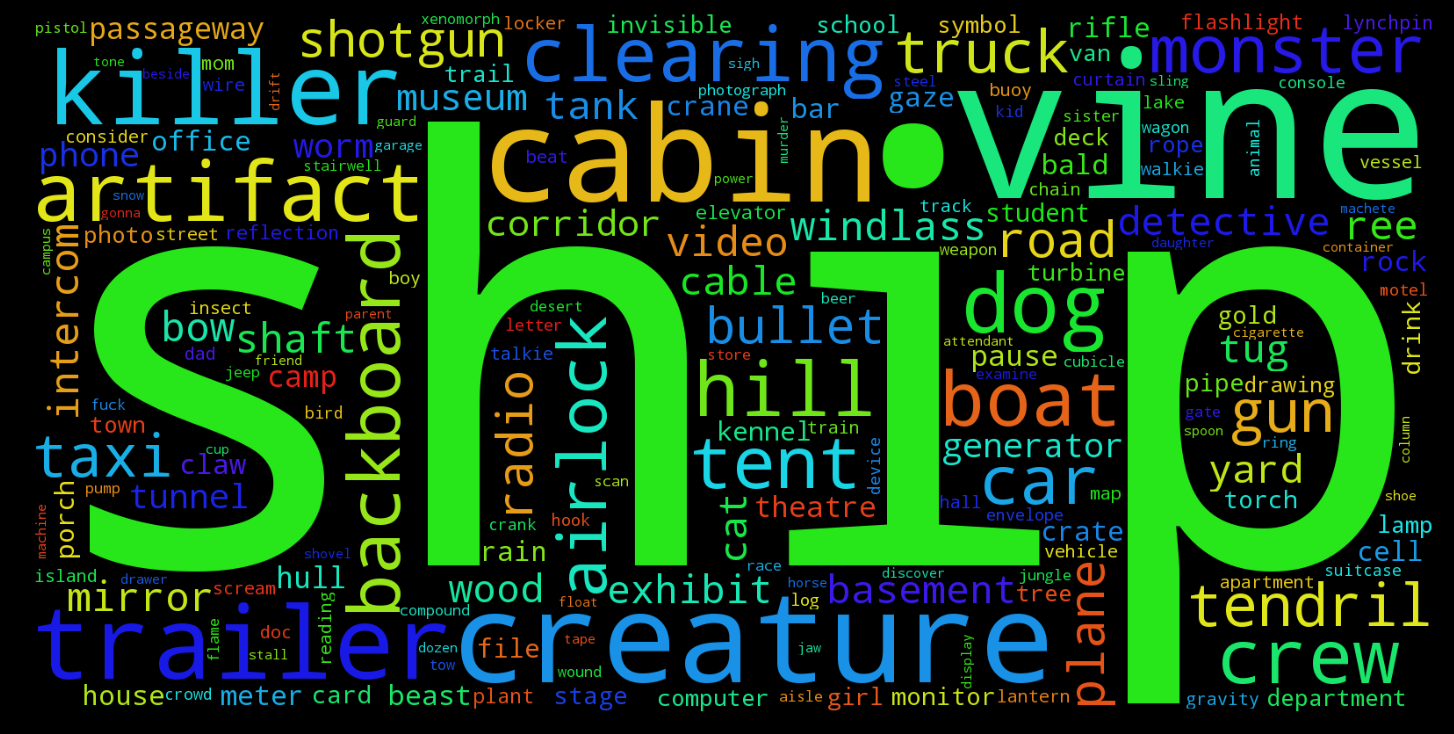

In [272]:
# Wordcloud image for Horror genre
wordcloud_tfidf("Horror")

Number of movie scripts in genre: 10
Movie scripts represented in the image
['S. Darko (2009)', '8MM (1999)', 'Source Code (2011)', 'Chronicle (2012)', 'Memento (2000)', 'Limitless (2011/I)', 'Angels & Demons (2009)', 'Color of Night (1994)', 'Lost Highway (1997)', 'Super 8 (2011)']


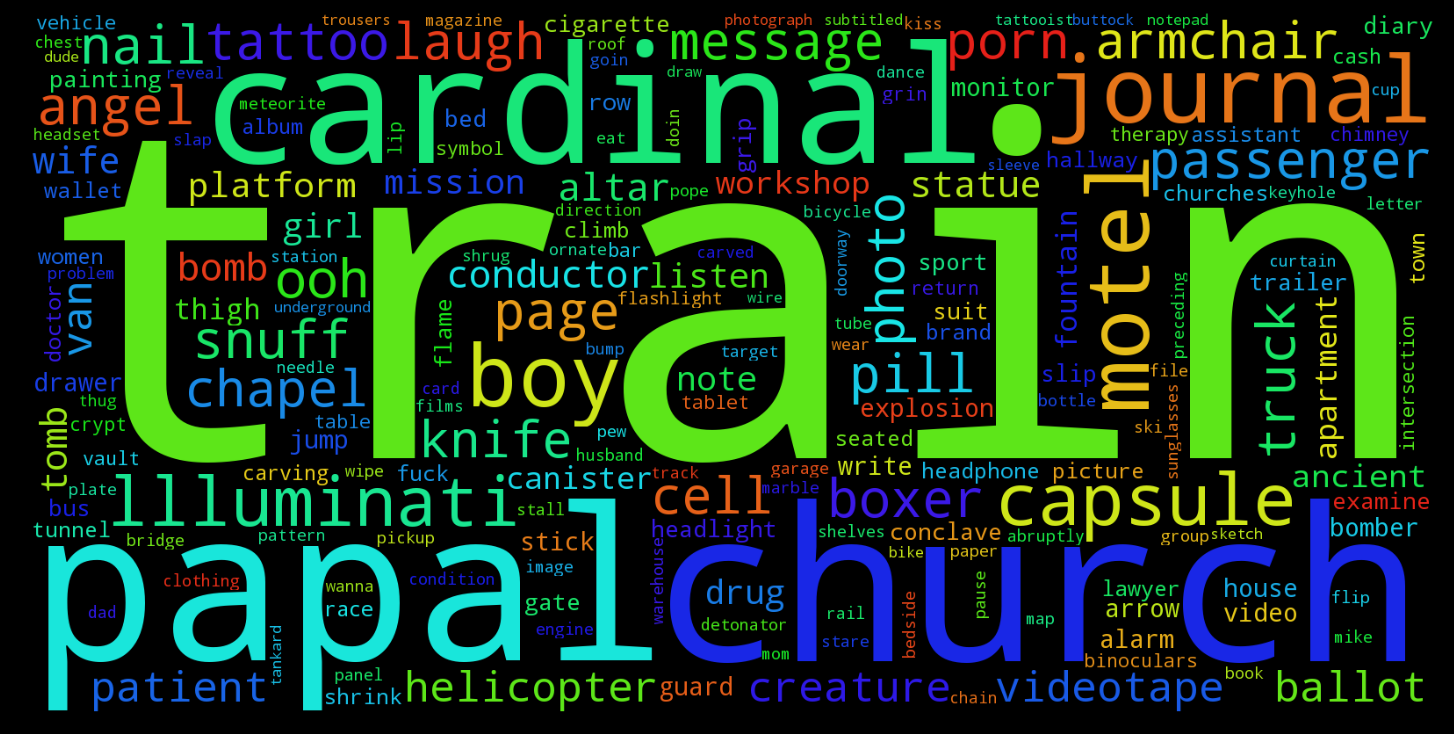

In [273]:
# Wordcloud image for Mystery genre
wordcloud_tfidf("Mystery")

### Analysis of the Wordcloud images
The best representation of a genre is clearly the crime genre, which is a lot more specific than other genres which are displayed here. Words like *gun*, *cell*, *vault*, *guard*, *casino*, *shotgun* and *profanities (fuck)* are common in the image, which really reflects the themes of crime movies.

The image for the action genre includes many words related to weapons, with the word *sword* the most obvious one. Words related to transport and creatures (*dragon*, *alien* and *vampire*) are also common. All in all, a fairly good representation of the action genre.

The comedy genre has the problem of being a very broad genre, many movies can fall into that category. The word *nun* is somehow very popular within the movies in the dataset that make up the comedy genre and profanites have a strong presence as well.

The same thing can be described of the drama genre. Movies that are consider drama can have many different themes and subjects, so words related to transport stand out.

Other genres have considerable less words to play with and that is reflected in their wordclouds, movies within the genres have much more weight in the images.